In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries, XAIModels
from tsx.xai import evaluation as eva

from data_util import *
from viz import *

import itertools
import pandas as pd
from biokit.viz import corrplot

# Load Data set
- Dataset of Beijin pollution
- Learns pollution for 128 historical steps
- Data is normalized when fitting into the model.

In [3]:
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

# Load data
df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)
samples_size = 100

# Load Explanations and Models from File

The explanations was generated for each options in:
- Scales (Synchronous, Asynchronos )
- Replacement Methods for perturbation (zeros, local_mean, global_mean)
- Models (lstm, wavenet) as (rnn, cnn) based line models

Notice:
- An option is an XAI model, e.g. async-zeros as asynchronous with zeros replacement for perturbation
- An explanation is an averaging over 10 random instances

In [4]:
X_test, y_test, options = np.load('data/explanations_and_test_set_w8.npy', allow_pickle=True)

# An option contain explanations, matching with instance in X_test
print(X_test.shape, y_test.shape, options[0]["explanations"].shape)

# Models
wavenet = tf.keras.models.load_model(f"data/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model("data/lstm_mts_128_1.h5")

(500, 128, 7) (500,) (500, 7, 128)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

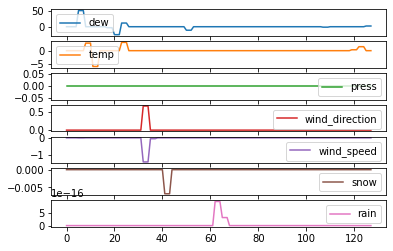

In [5]:
e = options[0]["explanations"][1]
pd.DataFrame(e.T, columns=independents).plot(subplots=True)

In [6]:
# Functions to perturb test set
def replacements(t, method='zeros', v=0, **kwargs):
    # t ~ (nfeatures x nsteps)
    if method == 'zeros':
        # Calculate zeros replacements
        r = np.zeros_like(t)
    if method== 'constant':
        # ! Be careful when the input data is normalized, 
        #   so this will make output significant change.
        r = np.zeros_like(t)
        r.fill(v)
    if method == 'mean':
        # Calculate means replacements
        v = t.mean(axis=1)
        r = np.ones_like(t) * v.reshape(t.shape[0], -1)
    if method == 'max':
        v = t.max(axis=1)
        r = np.ones_like(t) * v.reshape(t.shape[0], -1)
    if method == 'min':
        v = t.min(axis=1)
        r = np.ones_like(t) * v.reshape(t.shape[0], -1)
    if method == 'random':
        r = np.random.rand(*t.shape)
    return r

def mask(t, axis=1, random=0):
    # Create a mask based on 90 percentile of x_coef (features, steps)
    #   > 1 mean on , 0 means off (disabled)
    percentile = 90
    upper = np.percentile(t, percentile, axis=axis, interpolation="higher")
    if upper.ndim == 1: 
        upper = upper.reshape(t.shape[0], -1)
    
    lower = np.percentile(t, 100 - percentile, axis=axis, interpolation="lower")
    if lower.ndim == 1:
        lower = lower.reshape(t.shape[0], -1)

    m = (t != 0) * ((t > upper) + (t < lower))
    m = 1 - m   # reverse to have 1 = on, 0 = off

    # Random and ensure the same number of changed in percentile.
    if random == 1:
        m = m.ravel()
        np.random.shuffle(m)
        m = m.reshape(t.shape)

    if random == 2:
        np.apply_along_axis(np.random.shuffle, axis=1, arr=m)
    return m

def perturb(t, m, r):
    if m.T.shape == t.shape:
            m = m.T
    z = np.array(t, copy=True)
    z = t * m + r * (1 - m)
    # z[1-m] = r[1-m]   
    return z

def perturb_X(X, x_coef, method="zeros", axis=None, percentile=90, random=False, **kwargs):
    """ Perturb X based on coefficient or explanations.
        :param X: list of ndarray of shape (nfeatures, ncolumns). In time series it will be (nfeatures, nsteps)
        :param x_coef: if it is None, then random is used.
        :param axis: 
            - 1 : get percentile rowwise -> get 90 percentile per feature
            - None: consider x_coef as an array -> get 90 percentile overall
        :param method: perturbation method to generate perturbed test set.
        :param random:
            - 0/False: no random, use percentile
            - 1/True: use random in general
            - 2 : random only variables having segments changed
    """

    def _f(t, x_coef):
        # m = mask_percentile(x_coef, percentile, axis=axis, random=random)
        m = mask(x_coef, axis=axis, random=random)
        r = replacements(t, method=method, **kwargs)
        z = perturb(t, m, r) # 1: on, 0: off/disabled/perturbed
        return z

    Z = np.array([_f(x, x_coef[i]) for i, x in enumerate(X)])

    return Z


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

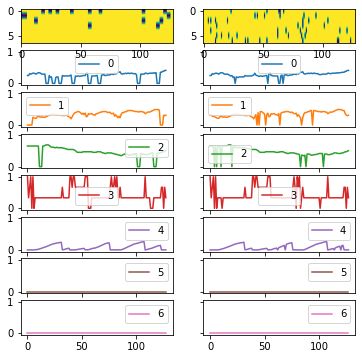

In [42]:

# Test:
t = perturb_X(X_test[:5], options[0]["explanations"])

# Test:
e = options[0]
x_coef = e["explanations"][0]
sample = X_test[0]
m1 = mask(x_coef, axis=1)
m2 = mask(x_coef, axis=1, random=1)
r = replacements(sample)
z1 = perturb(sample, m1, r)
z2 = perturb(sample, m2, r)

fig, axes = plt.subplots(8, 2, sharex=True, sharey=True,figsize=(6,6))
plt.subplot(8,2,1)
plt.imshow(m1, aspect='auto')
plt.subplot(8,2,2)
plt.imshow(m2, aspect='auto')
pd.DataFrame(z1).plot(subplots=True, ax=axes[1:,0])
pd.DataFrame(z2).plot(subplots=True, ax=axes[1:,1])


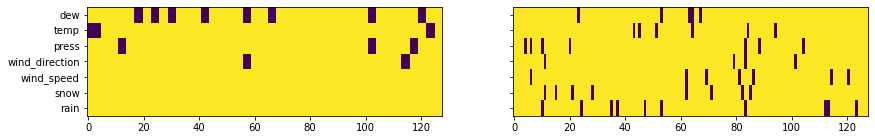

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14,2), sharey=True)
axes[0].imshow(m1, interpolation='nearest', aspect='auto')
axes[0].set_yticks(np.arange(len(independents)))
axes[0].set_yticklabels(independents, minor=False)
axes[1].imshow(m2, interpolation='nearest', aspect='auto')

async lstm (7, 128)


Text(0.5, 0.98, 'Mask for important coef > 90 Percentile or < 10')

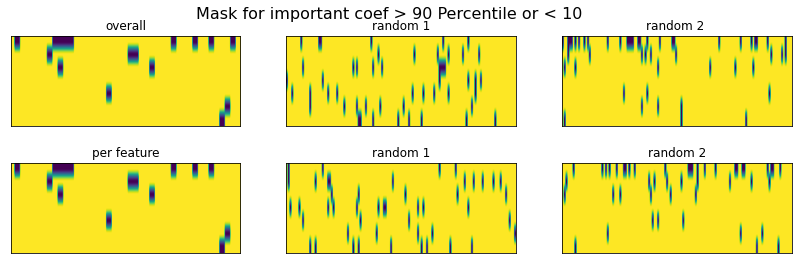

In [68]:
# Compare the difference between overall percentile and percentile per feature w/wo random

# Test:
e = options[0]
idx = np.random.randint(0,500)
x_coef = e["explanations"][idx]
sample = X_test[idx]

print(e["scale"], e["model"], x_coef.shape)

# Get absolute value for weight, because LIME could be negative -> 90 percentile might not work.
m1 = mask(x_coef, axis=None)
m2 = mask(x_coef, axis=None,random=1)
m3 = mask(x_coef, axis=None,random=2)

m4 = mask(x_coef, axis=1)
m5 = mask(x_coef, axis=1, random=1)
m6 = mask(x_coef, axis=1, random=2)


fig, axes = plt.subplots(2, 3, figsize=(14, 4))
ax = axes[0, 0]
ax.imshow(m1, aspect='auto')
ax.set_title("overall")
ax = axes[0, 1]
ax.imshow(m2, aspect='auto')
ax.set_title("random 1")
ax = axes[0, 2]
ax.imshow(m3, aspect='auto')
ax.set_title("random 2 ")
ax = axes[1, 0]
ax.imshow(m4, aspect='auto')
ax.set_title("per feature")
ax = axes[1, 1]
ax.imshow(m5, aspect='auto')
ax.set_title("random 1")
ax = axes[1, 2]
ax.imshow(m6, aspect='auto')
ax.set_title("random 2")

plt.subplots_adjust(hspace=.4)

plt_hide_ticks(fig)
plt.suptitle("Mask for important coef > 90 Percentile or < 10", fontsize=16)
# Test perturb_X
#r = replacements(x_arr, method="zeros")
#z = perturb(x_arr, m, r)

#e = explanations[0]
#xcoef = e["xcoef"]
#X_perturbed = perturb_X(X, xcoef, method="zeros")


# Methodology for experiments.

## Root Mean Squared Error in original as base line
1. Fit directy X, y_true, y_pred to f(x) to get the baseline score

## rmse in 90 percentile of explanations
1. For each XAI model we generate a perturbed test set
1. Fit to model and record rmse of perturbed test to the dict
1. Save all scores to the dict {"scale": ..., "model": ...., "method": ...., "xcoef": ....., "rmse": ....}
    - xcoef as explanations.
    - rmse as root mean squared error score (lower better)

## rmse in random perturbed
1. Generate a random perturbed set, notice that:
    - the number of changes =  perturbed test set

## Step 1: RMSE of original Test Set X
## Step 2: RMSE of overall 90 percentile of explanations
## Step 3: RMSE of overall Random
- number of changes in random = overall 90 percentile of explanations (in step 1)

In [9]:
import copy
import tqdm
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error

def rmse(y_true, y_pred):
    s = mean_squared_error(y_true, y_pred)
    return np.sqrt(s)

def r2(y_true, y_pred):
    s = r2_score(y_true, y_pred)
    return s
def qm_rmse_exp(X, y_true, explanations, metrics="rmse", axis=None, absolute=False, random=1, **kwargs):
    # Calculate quality measure for each explanation
    t = copy.deepcopy(options)
    for opt in t:
        exp = opt["explanations"]        
        model = eval(opt["model"])
        fn = eval(metrics)
        
        if absolute:
            exp = np.abs(exp)
        
        #1 Get original rmse for X
        y_pred = model.predict(X).ravel()
        s = fn(y_true, y_pred)
        opt.update({f"{metrics}_original": s})

        #2 Create perturbed test set + rmse
        X_lime = perturb_X(X, x_coef=exp, axis=axis, **kwargs)
        y_pred = model.predict(X_lime).ravel()
        s = fn(y_true, y_pred)
        opt.update({f"{metrics}_lime": s})

        #3 Random - same x-coef to get number of changes.
        X_random = perturb_X(X, x_coef=exp, axis=axis, random=random, **kwargs)
        y_pred = model.predict(X_random).ravel()
        s = fn(y_true, y_pred)
        opt.update({f"{metrics}_random": s})
        
    return t

def eva_explainations(exp, model='lstm', metrics="rmse"):
    eva_df = pd.DataFrame(list(exp))
    eva_df = eva_df.drop("explanations", axis=1)

    d1 = f"{metrics}_diff_random"
    d2 = f"{metrics}_diff_lime"
    d3 = f"{metrics}_diff"

    eva_df[d1] = eva_df.eval(f"{metrics}_random - {metrics}_original")
    eva_df[d2] = eva_df.eval(f"{metrics}_lime - {metrics}_original")
    eva_df[d3] = eva_df.eval(f"{metrics}_lime - {metrics}_random")
    
    sign = "<=" # r2
    if metrics in ["rmse", "mse"]:
        sign = ">="
    
    eva_df["ass_hold"] = eva_df.eval(f"{d1} {sign} 0 and {d2} {sign} 0 and {d3} {sign} 0")

    # Select columns to presents
    c =["scale", "model", "method", 
        f"{metrics}_original",
        d1, d2, d3, "ass_hold"]
    tt = eva_df.loc[:, c]
    result = tt.query(f"model == '{model}' ")
    return result

# Evaluation quality for Regression task

Assumptions to be used: 
\begin{equation}
    err(X) < err(X_{random}) < err(X_{p90})
\end{equation}
- with X: Original test set
- $X_{random}$: Randomly perturbed X, based on number of changes in $X_p90$
- $X_{p90}$: Perturbed based on values larger than 90 percentile threshold.

We expect to see:
- $rmse(X) <= rmse(X_{random}) < rmse(X_{p90})$
- alternative $0 <= diff_{random} < diff_{p90}$ in comparison with rmse X
    - $diff_{random} = rmse_{random} - rmse_{origingal}$
    - $diff_{p90} = rmse_{p90} - rmse_{origingal}$
    - $diff = diff_{p90} - diff_{random} = rmse_{p90} - rmse_{random}$

### Assumption would be hold only if: $0 <= diff_{random} < diff_{p90}  \land  diff > 0 $ 

In [10]:
# Evaluation Result for lstm
from IPython.display import Math, display

metrics = "rmse"    #   "rmse", "mse", "r2"
method = "zeros"    #   "zeros", "min", "max", "mean", "random", "constant, v=5"
N = 100
if metrics == "r2":
    _math_text_ = r"""$\text{Expect to see: } 0 >= diff_{random} >= diff_{lime}  \land  diff <= 0 $"""
else:
    _math_text_ = r"""$\text{Expect to see: } 0 <= diff_{random} <=diff_{p90}  \land  diff >= 0 $"""

In [11]:
test_case_1 = "Overall 90 percentile"
opt1 = qm_rmse_exp(X_test[:N], y_test[:N], options[:N], axis=None, method=method, metrics=metrics, random=2)

In [12]:
# Case 1
display(Math(_math_text_))
print(test_case_1)
df = eva_explainations(opt1, "lstm", metrics)
(df.style
    .highlight_max(axis=0, subset=[f"{metrics}_diff_random", f"{metrics}_diff_lime"])
    .applymap(lambda s: 'color: %s' % ('green' if s else ''), subset=["ass_hold"])
)

<IPython.core.display.Math object>

Overall 90 percentile


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_lime,rmse_diff,ass_hold
0,async,lstm,zeros,0.056891,0.014513,0.065241,0.050728,True
2,async,lstm,local_mean,0.056891,0.008431,0.020897,0.012466,True
4,async,lstm,global_mean,0.056891,0.015542,0.043971,0.028429,True
6,sync,lstm,zeros,0.056891,0.013539,0.011636,-0.001903,False
8,sync,lstm,local_mean,0.056891,0.011604,0.010240,-0.001364,False
10,sync,lstm,global_mean,0.056891,0.008158,0.018223,0.010065,True


In [13]:
df =eva_explainations(opt1, "wavenet", metrics)
(df.style
    .highlight_max(axis=0, subset=[f"{metrics}_diff_random", f"{metrics}_diff_lime"])
    .applymap(lambda s: 'color: %s' % ('green' if s else ''), subset=["ass_hold"])
)

,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_lime,rmse_diff,ass_hold
1,async,wavenet,zeros,0.037354,0.026303,0.045815,0.019512,True
3,async,wavenet,local_mean,0.037354,0.021633,0.033503,0.011871,True
5,async,wavenet,global_mean,0.037354,0.031507,0.043071,0.011565,True
7,sync,wavenet,zeros,0.037354,0.034068,0.022732,-0.011336,False
9,sync,wavenet,local_mean,0.037354,0.033402,0.012592,-0.020810,False
11,sync,wavenet,global_mean,0.037354,0.024900,0.029058,0.004158,True


In [14]:
test_case_2 = "Per-feature 90 percentile"
opt2 = qm_rmse_exp(X_test, y_test, options, axis=1, method=method, metrics=metrics, random=2)

In [15]:
# Case 2
display(Math(_math_text_))
print(test_case_2)
df = eva_explainations(opt2, "lstm", metrics)
(df.style
    .highlight_max(axis=0, subset=[f"{metrics}_diff_random", f"{metrics}_diff_lime"])
    .applymap(lambda s: 'color: %s' % ('green' if s else ''), subset=["ass_hold"])
)

<IPython.core.display.Math object>

Per-feature 90 percentile


,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_lime,rmse_diff,ass_hold
0,async,lstm,zeros,0.084996,0.014406,0.039708,0.025302,True
2,async,lstm,local_mean,0.084996,0.007117,0.014588,0.007471,True
4,async,lstm,global_mean,0.084996,0.014510,0.033273,0.018763,True
6,sync,lstm,zeros,0.084996,0.017042,0.014500,-0.002541,False
8,sync,lstm,local_mean,0.084996,0.013925,0.010055,-0.003870,False
10,sync,lstm,global_mean,0.084996,0.018457,0.013312,-0.005145,False


In [16]:
df = eva_explainations(opt2, "wavenet", metrics)
(df.style
    .highlight_max(axis=0, subset=[f"{metrics}_diff_random", f"{metrics}_diff_lime"])
    .applymap(lambda s: 'color: %s' % ('green' if s else ''), subset=["ass_hold"])
)

,scale,model,method,rmse_original,rmse_diff_random,rmse_diff_lime,rmse_diff,ass_hold
1,async,wavenet,zeros,0.085782,0.016954,0.029340,0.012387,True
3,async,wavenet,local_mean,0.085782,0.018988,0.016259,-0.002728,False
5,async,wavenet,global_mean,0.085782,0.019412,0.025819,0.006407,True
7,sync,wavenet,zeros,0.085782,0.026301,0.010073,-0.016228,False
9,sync,wavenet,local_mean,0.085782,0.020207,0.007678,-0.012529,False
11,sync,wavenet,global_mean,0.085782,0.025411,0.007542,-0.017869,False
